In [1]:
!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-02-10 07:42:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.237.57.234, 35.169.40.78, 34.236.27.247, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.237.57.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.13M  40.0MB/s    in 0.3s    

2020-02-10 07:42:01 (40.0 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
import torch
import torch.nn as nn
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [0]:
class VAE(nn.Module):
    def __init__(self, nz = 32):
        super(VAE, self).__init__()
        self.nz = nz

        self.encoder_fc = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True)
        )
        self.mu_fc = nn.Linear(256, nz)
        self.logvar_fc = nn.Linear(256, nz)
        self.decoder_fc = nn.Sequential(
            nn.Linear(nz, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std, device = std.get_device(), requires_grad = True)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder_fc(x)
        return self.mu_fc(x), self.logvar_fc(x)

    def decode(self, z):
        return self.decoder_fc(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

def loss_func(recon_x, x, mu, logvar):
    recon_loss = torch.sum(nn.MSELoss(reduction = 'none')(recon_x, x), dim = [1]) / x.size(0)
    kl_divergence = torch.sum((mu.pow(2) + logvar.exp() - 1 - logvar) * 0.5, dim = [1]) / x.size(0)
    return (recon_loss + kl_divergence).mean()

def weight_init(net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.uniform_(-0.1, 0.1)
            if m.bias is not None:
                m.bias.data.zero_()

In [0]:
def create_mnist_dataset(dataset_path, bs, is_train):
    return torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            dataset_path, train = is_train,
            download = True, transform = torchvision.transforms.ToTensor()
        ),
        batch_size = bs,
        shuffle = True if is_train else False
    )

def train(config):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    train_dataset = create_mnist_dataset(config['dataset_path'], config['batch_size'], True)
    eval_dataset = create_mnist_dataset(config['dataset_path'], config['batch_size'], False)

    net = VAE().to(device)
    full_model_path = config['model_path'] + config['model_name']
    if config['load_pretrained_model']:
        net.load_state_dict(torch.load(full_model_path))
        print('Load the pretrained model from %s successfully!' % full_model_path)
    else:
        weight_init(net)
        if not os.path.exists(config['model_path']):
            os.makedirs(config['model_path'])
        print('First time training!')
    net.train()
    
    optimizer = torch.optim.Adam(net.parameters(), lr = config['learning_rate'], betas = [0.5, 0.999])

    summary = SummaryWriter(config['summary_path'])
    total_iter = 1

    for e in range(1, config['epoch'] + 1):
        for idx, (x, _) in enumerate(train_dataset):
            x = x.to(device).view(-1, 784)
            optimizer.zero_grad()
            recon_x, mu, logvar = net(x)
            loss = loss_func(recon_x, x, mu, logvar)
            loss.backward()
            optimizer.step()

            print('[Epoch %d|Train Batch %d] Loss = %.6f' % (e, idx, loss.item()))
            summary.add_scalar('Train/Loss', loss.item(), total_iter)
            total_iter += 1

        if e % 5 == 0:
            net.eval()
            eval_losses = []
            with torch.no_grad():
                for idx, (x, _) in enumerate(eval_dataset):
                    x = x.to(device).view(-1, 784)
                    recon_x, mu, logvar = net(x)
                    loss = loss_func(recon_x, x, mu, logvar)
                    
                    print('[Epoch %d|Eval Batch %d] Loss = %.6f' % (e, idx, loss.item()))
                    eval_losses.append(loss.item())

                mean_eval_loss = np.mean(eval_losses)
                summary.add_scalar('Eval/Loss', mean_eval_loss, e)
            net.train()

        if e % 5 == 0:
            with torch.no_grad():
                fake_z = torch.randn((64, net.nz)).to(device)
                fake_imgs = net.decode(fake_z).view(-1, 1, 28, 28).detach()
                fake_imgs = torchvision.utils.make_grid(fake_imgs, padding = 2, normalize = True).detach().cpu().numpy()
                summary.add_image('Eval/Fake_imgs_after_%d_epochs' % e, fake_imgs, e)

        if e % 2 == 0:
            torch.save(net.state_dict(), full_model_path)

    summary.close()

def fake(config):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    net = VAE().to(device)
    net.load_state_dict((torch.load(config['model_path'] + config['model_name'])))
    net.eval()

    with torch.no_grad():
        fake_z = torch.randn((64, net.nz)).to(device)
        fake_imgs = net.decode(fake_z).view(-1, 1, 28, 28).detach()
        plt.figure(figsize = (8, 8))
        plt.axis('off')
        plt.title('Fake images')
        plt.imshow(np.transpose(torchvision.utils.make_grid(fake_imgs, padding = 2, normalize = True).cpu(), (1, 2, 0)))
        plt.show()

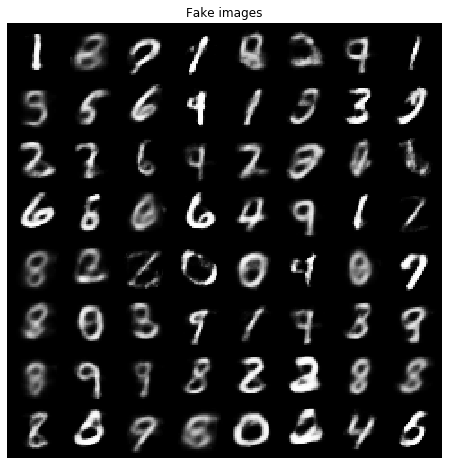

In [12]:
config = {
    'is_train' : True,
    'load_pretrained_model' : False,
    'model_path' : './model/',
    'model_name' : 'model.pkl',
    'summary_path' : './summary/',
    'dataset_path' : './data/',
    'batch_size' : 128,
    'epoch' : 30,
    'learning_rate' : 1e-2
}
if config['is_train']:
    train(config)
else:
    fake(config)

In [11]:
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(config['summary_path']))

get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://ab22f905.ngrok.io
